In [37]:
using Pkg
pkg"activate ."

In [38]:
pkg"status"

    Status `~/projetos/abel/apresentacoes/2019-05-31-ppgm/Project.toml`
  [ecbce9bc] BenchmarkProfiles v0.2.0
  [336ed68f] CSV v0.5.5
  [1b53aba6] CUTEst v0.6.0+ [`~/projetos/jso/CUTEst.jl`]
  [5a1c9e79] CaNNOLeS v0.1.0 #master (https://github.com/JuliaSmoothOptimizers/CaNNOLeS.jl)
  [a93c6f00] DataFrames v0.18.2
  [28b8d3ca] GR v0.39.1
  [ee98c95a] HSL v0.1.0 [`~/projetos/jso/HSL.jl`]
  [c601a237] Interact v0.10.2
  [7782544b] JSOSolvers v0.0.0 [`~/projetos/jso/JSOSolvers.jl`]
  [4076af6c] JuMP v0.18.6
  [ba0b0d4f] Krylov v0.3.0
  [5c8ed15e] LinearOperators v0.5.4
  [a4795742] NLPModels v0.8.0
  [792afdf1] NLPModelsJuMP v0.3.0
  [429524aa] Optim v0.18.1
  [91a5bcdd] Plots v0.25.1
  [581a75fa] SolverBenchmark v0.1.0
  [a513cd03] SolverTools v0.1.2 [`~/projetos/jso/SolverTools.jl`]
  [b8865327] UnicodePlots v1.1.0


# JuliaSmoothOptimizers

## Pacotes para Otimização Contínua em Julia

**Abel Soares Siqueira**

UFPR, Curitiba/PR, Brasil

**Dominique Orban**

GERAD/École Polytechnique de Montréal, Montreal/QC, Canada

![](jsologo.png)

**O que é?**

- Ferramentas de Álgebra Linear e Otimização para desenvolvedores/pesquisadores/acadêmicos;
- Também desenvolvemos *solvers (otimizadores)*, focando em problemas de larga-escala;
- Trabalho similar em PythonOptimizers.

![](JSO-network.png)

**Não tem**

- Variáveis inteiras;
- Sua própria linguagem de modelagem;
- Coleção completa de solvers.

# NLPModels

- Define modelos de programação não-linear e uma interface de acesso unificada;
- Alguns modelos são mais eficientes, outros mais simples;
- Criar um modelo novo é fácil.

In [39]:
using NLPModels

# ADNLPModel usa ForwardDiff (Diferenças finitas para aprox. a derivada)
adnlp = ADNLPModel(x -> (x[1] - 1)^2 + 100 * (x[2] - x[1]^2)^2,
    [-1.2; 1.0])

# CUTEst é uma biblioteca famosa. ROSENBR é o mesmo problema que o mostrado acima
using CUTEst
cnlp = CUTEstModel("ROSENBR")

using JuMP, NLPModelsJuMP
m = Model()
@variable(m, x[1:2])
setvalue(x, [-1.2; 1.0])
@NLobjective(m, Min, (x[1] - 1)^2 + 100 * (x[2] - x[1]^2)^2)

mpnlp = MathProgNLPModel(m)

for (name, nlp) in [("Autodiff", adnlp),
                    ("CUTEst", cnlp),
                    ("JuMP", mpnlp)]
    x = nlp.meta.x0
    println("Modelo $name")
    println("fx = ", obj(nlp, x))
    println("gx = ", grad(nlp, x))
    println("Hx = ", hess(nlp, x))
end
finalize(cnlp)

Modelo Autodiff
fx = 24.199999999999996
gx = [-215.6, -88.0]
Hx = [1330.0 0.0; 480.0 200.0]
Modelo CUTEst
fx = 24.199999999999996
gx = [-215.6, -88.0]
Hx = 
  [1, 1]  =  1330.0
  [2, 1]  =  480.0
  [2, 2]  =  200.0
Modelo JuMP
fx = 24.199999999999996
gx = [-215.6, -88.0]
Hx = 
  [1, 1]  =  1330.0
  [2, 1]  =  480.0
  [2, 2]  =  200.0


**Método de Newton modificado**

- Encontre $\rho_k \geq 0$ tal que $\nabla^2 f(x_k) + \rho_k I$ seja definida positiva;
- Encontre $d_k$ solução de $$\big(\nabla^2 f(x_k) + \rho_k I\big) d = -\nabla f(x_k); $$
- Encontre $\alpha_k > 0$ através de *backtracking* tal que
$$ f(x_k + \alpha_k d_k) \leq f(x_k) + \alpha_k \gamma \nabla f(x_k)^T d_k. $$

In [40]:
using LinearAlgebra

function newton(nlp :: AbstractNLPModel;  # Qualquer modelo
                x :: AbstractVector = copy(nlp.meta.x0),
                atol :: Real = √eps(eltype(x)),
                rtol :: Real = √eps(eltype(x)),
                max_f :: Int = 1000,
                max_time :: Real = 30.0,
                )
    Δt = 0.0
    start_time = time()
    
    T = eltype(x)
    λmin = sqrt(eps(T))
    fx = obj(nlp, x)
    gx = zeros(nlp.meta.nvar)
    grad!(nlp, x, gx)
    
    normgx = norm(gx)
    ϵ = atol + rtol * normgx
    
    resolvido = normgx < ϵ # Variável booleana
    cansado = sum_counters(nlp) > max_f || Δt > max_time
    
    while !(resolvido || cansado)
        Hx = Symmetric(Matrix(hess(nlp, x)), :L) # Declarado como matriz simétrica
        λ = 0.0
        G = cholesky(Hx, check=false)
        while !issuccess(G)
            λ = max(λmin, 10λ)
            G = cholesky(Hx + λ*I, check=false)
        end
        d = -(G \ gx)
        slope = dot(gx, d)
        t = one(T) # 1.0
        xt = x + t * d
        ft = obj(nlp, xt)
        while !(ft ≤ fx + 1e-4 * t * slope)
            t = t / 4
            xt = x + t * d
            ft = obj(nlp, xt)
        end
        
        x .= xt
        fx = ft
        grad!(nlp, x, gx)
        normgx = norm(gx)
        
        Δt = time() - start_time
        resolvido = normgx < ϵ
        cansado = sum_counters(nlp) > max_f || Δt > max_time
    end
    
    return x, fx, normgx, Δt, neval_obj(nlp), neval_grad(nlp), neval_hess(nlp)
end

newton (generic function with 1 method)

In [42]:
using Printf

cnlp = CUTEstModel("ROSENBR")

@printf("%10s  %8s  %8s  %4s  %4s  %4s\n",
        "f(x)", "‖∇f(x)‖", "Δt", "#f", "#g", "#H")
for nlp in [adnlp; cnlp; mpnlp]
    reset!(nlp) # reset counters
    x, fx, ngx, Δt, nf, ng, nH = newton(nlp) 
    @printf("%+10.4f  %8.2e  %8.2e  %4d  %4d  %4d\n",
            fx, ngx, Δt, nf, ng, nH)
end

finalize(cnlp)

      f(x)   ‖∇f(x)‖        Δt    #f    #g    #H
   +0.0000  2.03e-12  1.55e-04    29    23    22
   +0.0000  2.03e-12  1.96e-04    29    23    22
   +0.0000  2.03e-12  1.92e-04    29    23    22


- `ADNLPModel` é simples de usar, mas é ineficiente porque têm matrizes densas. É fácil de escrever pequenos problemas;
- `JuMP/MPB` é uma linguagem de modelagem completa, que é muito mais robusto, mas exige mais pacotes;
- `CUTEst` é o pacote usado para benchmarking tradicionalmente, ou seja, usado nas publicações.

**Framework**

- IDEIA!
- Protótipo, teste com `ADNLPModel`s;
- Teste com `CUTEst`;
- Melhore o método;
- Volte ao teste com `CUTEst` até ficar satisfeito;
- Implemente aplicações específicos/problemas grandes com JuMP.

**Protótipo e versão eficiente estão na mesma linguagem**

## Além do NLPModels

- Usar o NLPModels como base permite o uso de diversas fontes de problemas;
- Mas além disso, também permite a comparação com outros problemas de maneira mais fácil;
- Isso se baseia em
- Usar a saída `GenericExecutionStats` no pacote `SolverTools.jl`;
- Usar as funções de benchmark, também de `SolverTools.jl`;
- Usar as funções de comparação do pacote `SolverBenchmark.jl`.

In [43]:
using LinearAlgebra, Logging, SolverTools

function newton(nlp :: AbstractNLPModel;  # Qualquer modelo
                x :: AbstractVector = copy(nlp.meta.x0),
                atol :: Real = √eps(eltype(x)),
                rtol :: Real = √eps(eltype(x)),
                max_f :: Int = 1000,
                max_time :: Real = 30.0,
                max_iter :: Int = 1000
                )
    Δt = 0.0
    start_time = time()
    
    T = eltype(x)
    λmin = sqrt(eps(T))
    fx = obj(nlp, x)
    gx = zeros(nlp.meta.nvar)
    grad!(nlp, x, gx)
    
    normgx = norm(gx)
    ϵ = atol + rtol * normgx
    
    iter = 0
    @info log_header([:iter, :neval, :fx, :dual, :Δt],
                     [Int, Int, T, T, Float64],
                     hdr_override = Dict(:neval => "#f", :fx => "f(x)", :dual => "‖∇f(x)‖"))
    @info log_row(Any[iter, sum_counters(nlp), fx, normgx, Δt])
    
    resolvido = normgx < ϵ # Variável booleana
    cansado = sum_counters(nlp) > max_f || Δt > max_time || iter > max_iter
    
    while !(resolvido || cansado)
        Hx = Symmetric(Matrix(hess(nlp, x)), :L) # Declarado como matriz simétrica
        λ = 0.0
        G = cholesky(Hx, check=false)
        while !issuccess(G)
            λ = max(λmin, 10λ)
            G = cholesky(Hx + λ*I, check=false)
        end
        d = -(G \ gx)
        slope = dot(gx, d)
        t = one(T) # 1.0
        xt = x + t * d
        ft = obj(nlp, xt)
        while !(ft ≤ fx + 1e-4 * t * slope)
            t = t / 4
            xt = x + t * d
            ft = obj(nlp, xt)
        end
        
        x .= xt
        fx = ft
        grad!(nlp, x, gx)
        normgx = norm(gx)
        
        Δt = time() - start_time
        iter += 1
        resolvido = normgx < ϵ
        cansado = sum_counters(nlp) > max_f || Δt > max_time || iter > max_iter
        
        @info log_row(Any[iter, sum_counters(nlp), fx, normgx, Δt])
    end
    
    status = :unknown
    if resolvido
        status = :first_order
    elseif cansado
        if sum_counters(nlp) > max_f
            status = :max_eval
        elseif Δt > max_time
            status = :max_time
        else
            status = :max_iter
        end
    end
    return GenericExecutionStats(status, nlp, solution=x,
                    objective=fx, dual_feas=normgx, elapsed_time=Δt)
end

newton (generic function with 1 method)

- Mudando a saída para `GenericExecutionStats`, temos uma estrutura previsível.

In [44]:
nlp = ADNLPModel(x -> (x[1] - 1)^2 + 100 * (x[2] - x[1]^2)^2, [-1.2; 1.0])
stats = with_logger(ConsoleLogger()) do
    newton(nlp)
end
println(stats)

Generic Execution stats
  status: "first-order stationary"
  objective value: 2.1407799590134782e-24
  dual feasibility: 2.0334716414958886e-12
  primal feasibility: 0.0
  solution: [1.0  1.0]
  iterations: -1
  elapsed time: 0.15348315238952637


[ Info: iter   #f     f(x)      ‖∇f(x)‖   Δt        
[ Info: 0      2      2.4e+01   2.3e+02   0.0e+00 
[ Info: 1      5      4.7e+00   4.6e+00   1.5e-01 
[ Info: 2      10     4.2e+00   1.1e+01   1.5e-01 
[ Info: 3      14     3.8e+00   1.5e+01   1.5e-01 
[ Info: 4      17     3.4e+00   3.1e+01   1.5e-01 
[ Info: 5      20     2.4e+00   5.0e+00   1.5e-01 
[ Info: 6      24     2.0e+00   9.3e+00   1.5e-01 
[ Info: 7      27     1.6e+00   1.0e+01   1.5e-01 
[ Info: 8      30     1.1e+00   4.0e+00   1.5e-01 
[ Info: 9      33     1.1e+00   1.4e+01   1.5e-01 
[ Info: 10     36     5.6e-01   1.3e+00   1.5e-01 
[ Info: 11     40     4.2e-01   3.2e+00   1.5e-01 
[ Info: 12     43     2.9e-01   6.4e+00   1.5e-01 
[ Info: 13     46     1.6e-01   1.6e+00   1.5e-01 
[ Info: 14     49     1.3e-01   1.0e+01   1.5e-01 
[ Info: 15     52     3.7e-02   2.2e-01   1.5e-01 
[ Info: 16     56     2.4e-02   6.9e-01   1.5e-01 
[ Info: 17     59     1.4e-02   4.5e+00   1.5e-01 
[ Info: 18     62     1.2e-03

- Como a entrada e saída são previsíveis, podemos resolver um conjunto de problemas usando `solve_problems`;

In [45]:
pnames = ["ROSENBR", "BARD", "CUBE"]
problems = (CUTEstModel(p) for p in pnames)
df = solve_problems(newton, problems)

┌ Info: Name             nvar   ncon   status           Time      f(x)      Dual      Primal    
└ @ SolverTools /home/abel/projetos/jso/SolverTools.jl/src/bmark/run_solver.jl:63
┌ Info: ROSENBR          2      0      first_order      1.6e-04   2.1e-24   2.0e-12   0.0e+00 
└ @ SolverTools /home/abel/projetos/jso/SolverTools.jl/src/bmark/run_solver.jl:78
┌ Info: BARD             3      0      first_order      2.3e-04   8.2e-03   3.8e-08   0.0e+00 
└ @ SolverTools /home/abel/projetos/jso/SolverTools.jl/src/bmark/run_solver.jl:78
┌ Info: CUBE             2      0      first_order      3.0e-04   2.0e-18   1.8e-09   0.0e+00 
└ @ SolverTools /home/abel/projetos/jso/SolverTools.jl/src/bmark/run_solver.jl:78


,id,name,nvar,ncon,nequ,status,objective,elapsed_time,iter
,Int64,String,Int64,Int64,Int64,Symbol,Float64,Float64,Int64
1,1,ROSENBR,2,0,0,first_order,2.14078e-24,0.000160933,-1
2,2,BARD,3,0,0,first_order,0.00821488,0.000234127,-1
3,3,CUBE,2,0,0,first_order,1.97446e-18,0.000304937,-1


In [46]:
df = with_logger(NullLogger()) do
    solve_problems(newton, problems)
end

,id,name,nvar,ncon,nequ,status,objective,elapsed_time,iter
,Int64,String,Int64,Int64,Int64,Symbol,Float64,Float64,Int64
1,1,ROSENBR,2,0,0,first_order,2.14078e-24,0.000130177,-1
2,2,BARD,3,0,0,first_order,0.00821488,0.000164032,-1
3,3,CUBE,2,0,0,first_order,1.97446e-18,0.000197887,-1


In [47]:
df[:, [:name, :nvar, :objective, :elapsed_time, :neval_obj, :neval_grad, :neval_hess]]

,name,nvar,objective,elapsed_time,neval_obj,neval_grad,neval_hess
,String,Int64,Float64,Float64,Int64,Int64,Int64
1,ROSENBR,2,2.14078e-24,0.000130177,29,23,22
2,BARD,3,0.00821488,0.000164032,8,8,7
3,CUBE,2,1.97446e-18,0.000197887,35,28,27


- A saída de `solve_problems` é uma estrutura de tabela robusta (um DataFrame), e podemos aproveitá-la.

In [48]:
using SolverBenchmark

markdown_table(stdout, df, cols=[:name, :nvar, :objective, :elapsed_time])

|    name |  nvar | objective | elapsed_time |
|---------|-------|-----------|--------------|
| ROSENBR |     2 |   2.1e-24 |      1.3e-04 |
|    BARD |     3 |   8.2e-03 |      1.6e-04 |
|    CUBE |     2 |   2.0e-18 |      2.0e-04 |


In [49]:
latex_table(stdout, df, cols=[:name, :nvar, :objective, :elapsed_time])

\begin{longtable}[c]{lrrr}
\hline 
name & nvar & objective & elapsed\_time \\
\hline 
\endfirsthead
\multicolumn{4}{l}
{{\bfseries \tablename\ \thetable{} --- continued from previous page}} \\
\hline 
name & nvar & objective & elapsed\_time \\
\hline 
\endhead
\hline 
\multicolumn{4}{r}{{\bfseries Continued on next page}} \\
\hline 
\endfoot
\hline 
\endlastfoot
ROSENBR & \(    2\) & \( 2.1\)e\(-24\) & \( 1.3\)e\(-04\) \\
BARD & \(    3\) & \( 8.2\)e\(-03\) & \( 1.6\)e\(-04\) \\
CUBE & \(    2\) & \( 2.0\)e\(-18\) & \( 2.0\)e\(-04\) \\
\hline 
\end{longtable}


In [15]:
open("exemplo.tex", "w") do io
    latex_table(io, df, cols=[:name, :nvar, :objective, :elapsed_time])
end

- A próxima vantagem é poder utilizar outros métodos que já estão nesse formato.

**Ipopt**

- Um dos softwares de otimização abertos mais importantes;
- `Ipopt.jl` é o pacote com a interface para Julia, usada junto com `JuMP`;
- Nós criamos uma interface adicional.

In [50]:
using NLPModelsIpopt

nlp = ADNLPModel(x -> (x[1] - 1)^2 + 100 * (x[2] - x[1]^2)^2, [-1.2; 1.0])
stats = ipopt(nlp, print_level=0)
println(stats)

Generic Execution stats
  status: "first-order stationary"
  objective value: 3.743975643139474e-21
  dual feasibility: 3.732500974666708e-10
  primal feasibility: 0.0
  solution: [1.0  1.0]
  iterations: -1
  elapsed time: 0.204
  solver specifics:
    multipliers_U: [0.0  0.0]
    multipliers_L: [0.0  0.0]
    multipliers_con: ∅
    internal_msg: :Solve_Succeeded


In [52]:
df = with_logger(NullLogger()) do
    solve_problems(ipopt, problems, print_level=0)
end
df[:, [:name, :nvar, :objective, :elapsed_time, :neval_obj, :neval_grad, :neval_hess]]

,name,nvar,objective,elapsed_time,neval_obj,neval_grad,neval_hess
,String,Int64,Float64,Float64,Int64,Int64,Int64
1,ROSENBR,2,3.74398e-21,0.003,45,23,21
2,BARD,3,0.00821488,0.002,9,10,8
3,CUBE,2,1.75357e-24,0.002,58,29,27


- Sendo que os dois métodos tem a mesma saída, podemos usar o comando `bmark_solvers`.

In [53]:
solvers = Dict(:Newton => newton,
               :IPOPT => (nlp; kwargs...) ->
                    ipopt(nlp, print_level=0; kwargs...))
comp = with_logger(NullLogger()) do
    bmark_solvers(solvers, problems)
end

Dict{Symbol,DataFrame} with 2 entries:
  :IPOPT  => 3×34 DataFrame. Omitted printing of 27 columns…
  :Newton => 3×30 DataFrame. Omitted printing of 23 columns…

In [55]:
comp[:Newton]

,id,name,nvar,ncon,nequ,status,objective,elapsed_time,iter
,Int64,String,Int64,Int64,Int64,Symbol,Float64,Float64,Int64
1,1,ROSENBR,2,0,0,first_order,2.14078e-24,0.000130177,-1
2,2,BARD,3,0,0,first_order,0.00821488,0.000105858,-1
3,3,CUBE,2,0,0,first_order,1.97446e-18,0.000175953,-1


## JSOSolvers

- trunk: Método de Newton com região de confiança;
- lbfgs: BFGS com memória limitada e busca linear;
- tron: Newton com região de confiança para caixas;
- Larga escala, sem fatorações.

In [20]:
using BenchmarkProfiles, JSOSolvers, Logging

pnames = sort(CUTEst.select(max_var=2, contype=:unc))
problems = (CUTEstModel(p) for p in pnames)
solvers = Dict{Symbol,Function}(:lbfgs => lbfgs, :trunk => trunk)
stats = with_logger(ConsoleLogger()) do
    bmark_solvers(solvers, problems)
end

[ Info: Name             nvar   ncon   status           Time      f(x)      Dual      Primal    
[ Info: AKIVA            2      0      first_order      9.9e-04   6.2e+00   1.1e-08   0.0e+00 
[ Info: BEALE            2      0      first_order      1.2e-04   1.1e-24   7.0e-12   0.0e+00 
[ Info: BOXBODLS         2      0      first_order      2.0e-04   1.2e+03   9.7e-13   0.0e+00 
[ Info: BRKMCC           2      0      first_order      7.1e-05   1.7e-01   2.0e-14   0.0e+00 
[ Info: BROWNBS          2      0      first_order      2.2e-04   0.0e+00   0.0e+00   0.0e+00 
[ Info: CLIFF            2      0      first_order      1.2e-04   2.7e+00   7.6e+01   0.0e+00 
[ Info: CUBE             2      0      first_order      1.9e-04   3.7e-14   1.2e-05   0.0e+00 
[ Info: DANWOODLS        2      0      first_order      1.8e-04   4.3e-03   1.3e-06   0.0e+00 
[ Info: DENSCHNA         2      0      first_order      1.1e-04   1.2e-15   7.0e-08   0.0e+00 
[ Info: DENSCHNB         2      0      first_ord

Dict{Symbol,DataFrames.DataFrame} with 2 entries:
  :trunk => 37×30 DataFrames.DataFrame. Omitted printing of 23 columns…
  :lbfgs => 37×30 DataFrames.DataFrame. Omitted printing of 23 columns…

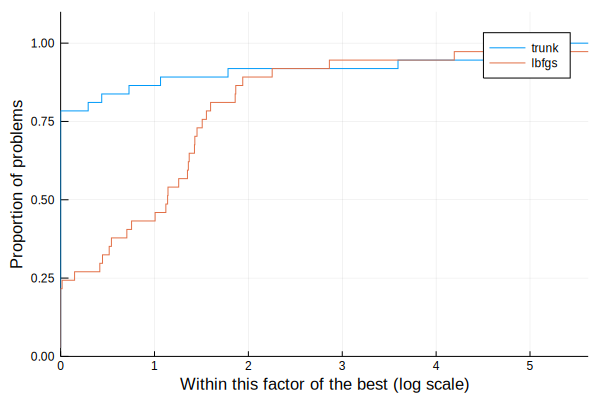

In [21]:
cost(df) = df.elapsed_time .+ (df.status .!= :first_order) * Inf
performance_profile(stats, cost)

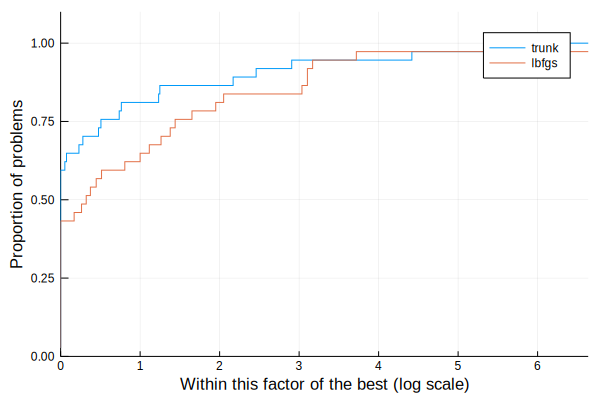

In [22]:
cost(df) = df.neval_obj .+ (df.status .!= :first_order) * Inf
performance_profile(stats, cost)

## Resumo até agora

- Ideia de um método;
- Escreve o método usando `NLPModels.jl` e `SolverTools.jl`;
- A entrada e a saída previsíveis;
- Use `SolverBenchmark.jl` para criar uma tabela em LaTeX;
- Compare contra solvers do `JSOSolvers.jl`, ou `Ipopt`, ou solvers de baixo nível (C/Fortran);
- Use `SolverBenchmark.jl` para gerar tabelas da comparação e perfis de desempenho;
- Faça melhorias:
  - Sistemas lineares
    - Fatorações: HSL.jl, LDLFactorizations.jl, MUMPS.jl, etc.;
    - Métodos iterativos: Krylov.jl
  - Novas estratégias;
  - Gasto de memórias desnecessários;

## Extensão: Quadrados Mínimos Não-Lineares

- Objetivo: $f(x) = \tfrac{1}{2}\|F(x)\|^2$;
- Saber $F$ diretamente dá mais poder ao *solver*;
- `AbstractNLSModel <: AbstractNLPModel`
- `LLSModel(A, b)`: $F(x) = Ax - b$;
- `ADNLSModel(F, x0, ne)`;
- `MathProgNLSModel` - Usa JuMP.

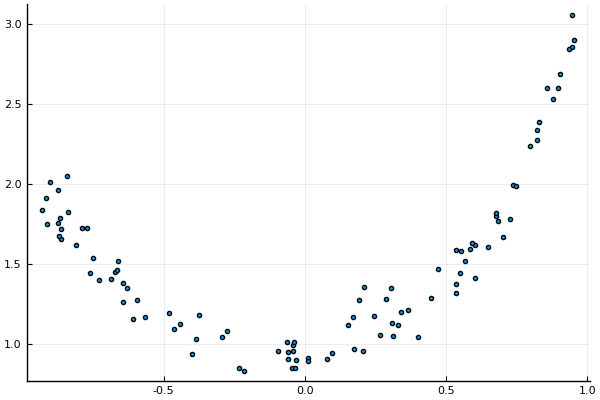

In [56]:
using Plots, Random
pyplot(size=(600,400))
Random.seed!(0)

N = 100
x = -1 .+ 2 * rand(N)
y = exp.(x.^2 + 0.2x) .+ randn(N) * 0.1
scatter(x, y, leg=false, ms=3)

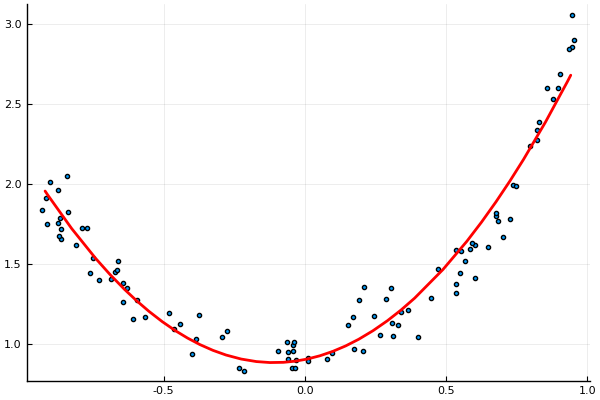

In [57]:
# y ~ β₀ + β₁x + β₂x²
X = [ones(N) x x.^2]
lls = LLSModel(X, y)
output = with_logger(NullLogger()) do
    newton(lls)
end
β = output.solution
h(x) = β[1] + β[2] * x + β[3] * x^2
scatter(x, y, leg=false, ms=3)
plot!(h, extrema(x)..., c=:red, lw=2)

**Quadrados Mínimos Lineares? CGLS**

In [58]:
using Krylov

β, stats = cgls(X, y)

([0.904324, 0.355016, 1.63022], 
Simple stats
  solved: true
  inconsistent: false
  residuals:  [  1.6e+01  3.5e+00  2.5e+00  1.3e+00 ]
  Aresiduals: [  1.7e+02  1.1e+01  8.0e+00  3.6e-13 ]
  status: solution good enough given atol and rtol
)

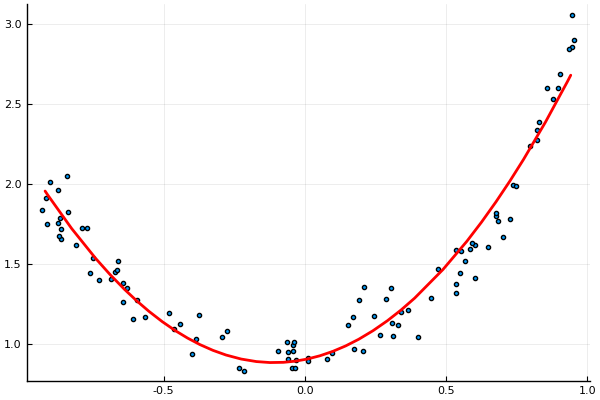

In [59]:
h(x) = β[1] + β[2] * x + β[3] * x^2
scatter(x, y, leg=false, ms=3)
plot!(h, extrema(x)..., c=:red, lw=2)

**Mais métodos para QM em Krylov: cgls, crls, lslq, lsmr, lsqr**

- Vide referências;

**Quadrados Mínimos Não-Lineares**

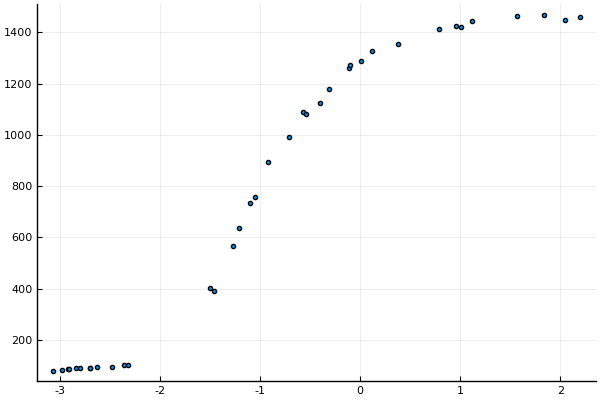

In [60]:
using CSV, DataFrames

# https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml
df = CSV.read("thurber.csv")
x, y = df.x, df.y
scatter(x, y, ms=3, leg=false)

- Modelo $h(\beta; x)$;
- Resíduo $r(\beta) = [h(\beta; x_i) - y_i]_{i=1,\dots,N}$;
- Chute inicial $\beta = [1000; 1000; 400; 40; 0.7; 0.3; 0.03]$;

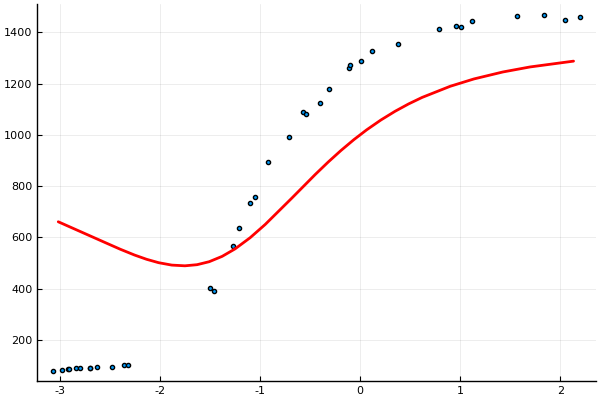

In [61]:
# y ~ (β₁ + β₂x + β₃x² + β₄x³) / (1 + β₅x + β₆x² + β₇x³)
h(β, xi) = (β[1] + β[2] * xi + β[3] * xi^2 +
    β[4] * xi^3) / (1 + β[5] * xi + β[6] * xi^2 + β[7] * xi^3)
r(β) = [h(β, x[i]) - y[i] for i = 1:N]
β₀ = [1000; 1000; 400; 40; 0.7; 0.3; 0.03]
scatter(x, y, leg=false, ms=3)
plot!(x->h(β₀,x), extrema(x)..., c=:red, lw=2)

- Resolva $\displaystyle \min_{\beta} \tfrac{1}{2}\|r(\beta)\|^2. $

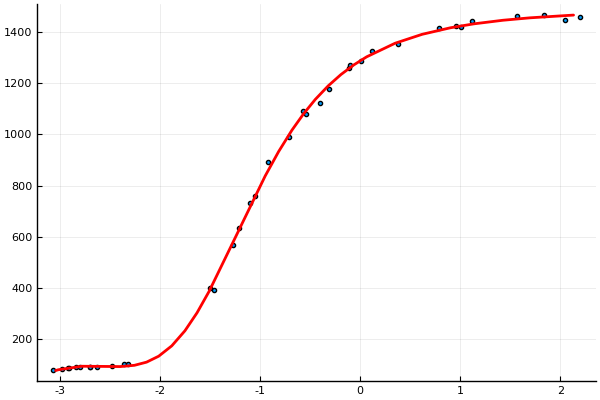

In [62]:
N = length(x)
nls = ADNLSModel(r, β₀, N)
output = with_logger(NullLogger()) do
    newton(nls)
end
β = output.solution

scatter(x, y, leg=false, ms=3)
plot!(x->h(β,x), extrema(x)..., c=:red, lw=2)

**Mais modelos**

- `CUTEst.jl` dá acesso a todos 1305 problemas do `CUTEst`, com API `CUTEst` e `NLPModels`. Contém uma ferramenta de selação de problemas;
- `AmplNLReader.jl` dá acesso a problemas escritos na linguagem de modelagem Ampl;
- `OptimizationProblems.jl` armazena problemas em formato JuMP;
- `NLSProblems.jl` armazena problemas de quadrados mínimos. Moré-Garbow-Hillstrom e outros modelos são implementados.

## CaNNOLeS

Constrained and NoNlinear Optimizer of Least Squares

\begin{align*}
             \min \quad & \tfrac{1}{2} \|F(x)\|^2 \\
    \text{suj. a} \quad & c(x) = 0.
\end{align*}

![](take-the-cannoles.png)

- Implementado em Julia usando essas ferramentas;
- Sistemas lineares usando MA57 (biblioteca de baixo nivel fechada) ou LDLFactorization.jl (Julia);

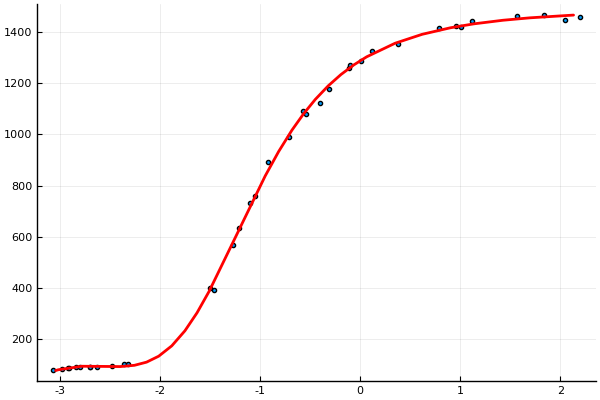

In [63]:
using CaNNOLeS

output = with_logger(NullLogger()) do
    cannoles(nls)
end
β = output.solution

scatter(x, y, leg=false, ms=3)
plot!(x->h(β,x), extrema(x)..., c=:red, lw=2)

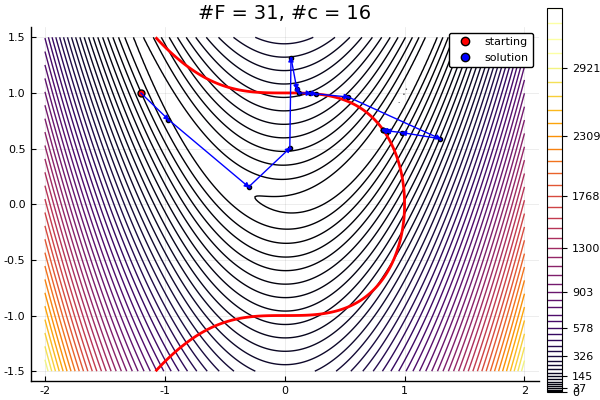

In [64]:
F(x) = [1 - x[1]; 10 * (x[2] - x[1]^2)]
c(x) = [x[1]^3 + x[2]^2 - 1.0]
x₀ = [-1.2; 1.0]
nls = ADNLSModel(F, x₀, 2, c=c, lcon=[0.0], ucon=[0.0])

f(x,y) = norm(F([x;y]))^2
contour(range(-2.0, 2.0, length=200), range(-1.5, 1.5, length=200), f, levels=(0.05:1.2:60).^2)
scatter!([x₀[1]], [x₀[2]], c=:red, ms=5, lab="starting")
contour!(range(-2.0, 2.0, length=200), range(-1.5, 1.5, length=200), (x,y)->c([x;y])[1], levels=[0.0], c=:red, lw=2)
x = copy(x₀)
for max_f = 1:1000
    reset!(nls)
    output = with_logger(NullLogger()) do
        cannoles(nls, max_f=max_f)
    end
    x⁺ = output.solution
    if x != x⁺
        scatter!([x⁺[1]], [x⁺[2]], c=:blue, ms=3, lab="")
        plot!([x[1], x⁺[1]], [x[2], x⁺[2]], c=:blue, l=:arrow, lab="")
        x = copy(x⁺)
    end
    if output.status == :first_order
        scatter!([x⁺[1]], [x⁺[2]], c=:blue, ms=3, lab="solution")
        title!("#F = $(neval_residual(nls)), #c = $(neval_cons(nls))")
        break
    end
end
plot!()

**Precisão múltipla**

In [65]:
nlp = ADNLPModel(x -> (x[1] - 1)^2 + 100 * (x[2] - x[1]^2)^2,
    [-1.2; 1.0])

ADNLPModel(Minimization problem Generic
nvar = 2, ncon = 0 (0 linear)
, Counters(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), getfield(Main, Symbol("##107#108"))(), getfield(NLPModels, Symbol("##104#107"))())

In [66]:
for T in [Float16, Float32, Float64]
    reset!(nlp)
    output = with_logger(NullLogger()) do
        newton(nlp, x = T[-1.2; 1.0])
    end
    println("T = $T")
    println("x = $(output.solution), ‖∇f‖ = $(output.dual_feas))")
end

T = Float16
x = Float16[-1.175, 1.379], ‖∇f‖ = 4.8164616911853715)
T = Float32
x = Float32[0.966141, 0.933182], ‖∇f‖ = 0.05667677769591364)
T = Float64
x = [1.0, 1.0], ‖∇f‖ = 2.0334716414958886e-12)


In [67]:
for p in 2 .^ (8:11)
    setprecision(p)
    reset!(nlp)
    output = with_logger(NullLogger()) do
        newton(nlp, x = BigFloat[-1.2; 1.0])
    end
    println("precisão = $p")
    println("x = $(output.solution), ‖∇f‖ = $(output.dual_feas))")
end

precisão = 256
x = BigFloat[1.0, 1.0], ‖∇f‖ = 3.4145398681571716e-38)
precisão = 512
x = BigFloat[1.0, 1.0], ‖∇f‖ = 2.040108840083797e-87)
precisão = 1024
x = BigFloat[1.0, 1.0], ‖∇f‖ = 1.516784410771994e-153)
precisão = 2048
x = BigFloat[1.0, 1.0], ‖∇f‖ = 2.433e-320)


# Lagrangiano Aumentado (Egmara Antunes)

In [68]:
include("Augmented-Lagrangian/AugLagModel.jl")
include("Augmented-Lagrangian/al.jl")

al (generic function with 1 method)

In [69]:
nlp = CUTEstModel("BT1")
output = with_logger(ConsoleLogger()) do
    al(nlp)
end
finalize(nlp)
println(output)

[ Info: iter   normgp    normcx    
[ Info: 0      6.0e-01   9.9e-01 


Generic Execution stats
  status: "first-order stationary"
  objective value: -1.0000004006587488
  dual feasibility: 3.694826867143054e-13
  primal feasibility: 4.026721178718162e-9
  solution: [1.0  5.85634e-16]
  iterations: 6
  elapsed time: 1.0580921173095703


[ Info: 1      2.8e-14   3.4e-01 
[ Info: 2      7.5e-16   1.1e-02 
[ Info: 3      2.8e-14   2.8e-04 
[ Info: 4      2.8e-14   6.7e-06 
[ Info: 5      6.4e-10   1.6e-07 
[ Info: 6      3.7e-13   4.0e-09 


## Futuro

**Extensão do NLPModels**

- $g(x) = \sum_{i=1}^N \sigma_i f_i(x) + \sigma_{NLS} \tfrac{1}{2}\|F(x)\|^2 + \sigma_{LS} \tfrac{1}{2}\|Ax - b\|^2$;
- Permite funções seraráveis $f_i$;
- Pode-se olhar para $f_i$ separadamente;
  - Gradiente estocástico;
  - Problemas multi-objetivos.

**Otimização de parâmetros**

- Precisamos de um solver sem derivadas robusto;
- NOMAD.jl está sendo criado
- Os parâmetros ótimos são escolhidos recebendo um solver e os problemas;
  - `opt_param = tune(solver, problems)`
  - `opt_solver = solver_with_parameters(solver, opt_param)`

**Publicações**

- Dahito, M.-A., & Orban, D. (2018). The Conjugate Residual Method in Linesearch and Trust-Region Methods (Cahier du GERAD No. G-2018-50). Montréal, QC, Canada: GERAD. doi:10.13140/RG.2.2.24634.08649 
- Estrin, R., Orban, D., & Saunders, M. A. (2018). LNLQ: An Iterative Method for Least-Norm Problems with an Error Minimization Property (Cahier du GERAD No. G-2018-40). Montréal, QC, Canada: GERAD. doi:10.13140/RG.2.2.34725.81123 
- Buttari, A., Orban, D., Ruiz, D., & Titley-Peloquin, D. (2018). A Tridiagonalization Method for Symmetric Saddle-Point and Quasi-Definite System (Cahier du GERAD No. G-2018-42). Montréal, QC, Canada: GERAD. doi:10.13140/RG.2.2.26337.20328 
- Orban, D., & Arioli, M. (2017). Iterative Solution of Symmetric Quasi-Definite Linear Systems (Vol. 3). SIAM. doi:10.1137/1.9781611974737 
- Estrin, R., Orban, D., & Saunders, M. A. (2017). LSLQ: An Iterative Method for Linear Least-Squares with an Error Minimization Property. SIAM Journal On Matrix Analysis, v(n), p–q. doi:10.13140/RG.2.2.17818.64966

*Submetido*

- Orban, D. & Siqueira, A. S. A Regularization Method for Constrained Nonlinear Least Squares. (Cahier du GERAD G-2019-17) Montreal, QC, Canada, GERAD. [10.13140/RG.2.2.11974.52809](https://www.gerad.ca/en/papers/G-2019-17).

*Em preparação*

- Siqueira, A. S., & Orban, D. JuliaSmoothOptimizers.